In [37]:
import numpy as np
import torch
from diffusers import PNDMScheduler, UNet2DConditionModel, AutoencoderKL
from torch import nn
from tqdm import tqdm
from transformers import CLIPTokenizer, CLIPTextModel, CLIPImageProcessor

%matplotlib inline
%reload_ext autoreload

In [38]:
class FrozenCLIP(nn.Module):
    def __init__(self):
        super(FrozenCLIP, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.text_encoder = CLIPTextModel.from_pretrained("riffusion/riffusion-model-v1", subfolder="text_encoder")
        self.tokenizer = CLIPTokenizer.from_pretrained("riffusion/riffusion-model-v1", subfolder="tokenizer",
                                                       device=self.device)
        self.feature_extractor = CLIPImageProcessor.from_pretrained("riffusion/riffusion-model-v1",
                                                                    subfolder="feature_extractor", device=self.device)

    @torch.no_grad()
    def embed_text(self, text):
        tokens = self.tokenizer(text, padding=True, return_tensors="pt")
        text_embeddings = self.text_encoder(**tokens).last_hidden_state.to(self.device)
        return text_embeddings


class SoundStyleTransferModel(nn.Module):
    def __init__(self):
        super(SoundStyleTransferModel, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scheduler = PNDMScheduler.from_config("riffusion/riffusion-model-v1", subfolder="scheduler")
        self.scheduler.prk_timesteps = np.array([])
        self.unet = UNet2DConditionModel.from_pretrained("riffusion/riffusion-model-v1", subfolder="unet").to(
            self.device)
        self.vae = AutoencoderKL.from_pretrained("riffusion/riffusion-model-v1", subfolder="vae").to(self.device)
        self.frozen_clip = FrozenCLIP()

    @torch.no_grad()
    def encode_images(self, images):
        return self.vae.encode(images).latent_dist.sample() * 0.18215

    @torch.no_grad()
    def decode_latents(self, latents):
        return self.vae.decode(latents / 0.18215).sample

    def forward(self, latents, text_embeddings, timesteps):
        result = self.unet(
            sample=latents,
            timestep=timesteps,
            encoder_hidden_states=text_embeddings
        ).sample

        return result

    @torch.no_grad()
    def diffuse(self, text_prompt, inference_steps=100):
        self.unet.eval()

        text_embeddings = self.frozen_clip.embembed_text(text_prompt)
        latents = torch.randn(1, 4, 64, 64).to(self.device)

        self.scheduler.set_timesteps(inference_steps)
        for t in tqdm(reversed(range(inference_steps)), total=inference_steps):
            with torch.no_grad():
                timesteps = torch.tensor([t], dtype=torch.int64, device=self.device)
                pred_noise = self.forward(latents, text_embeddings, timesteps)
                latents = self.scheduler.step(pred_noise, t, latents).prev_sample

        image = self.decode_latents(latents).permute(0, 2, 3, 1).clip(0, 1).cpu().squeeze().numpy()
        return image

An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch riffusion/riffusion-model-v1: riffusion/riffusion-model-v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


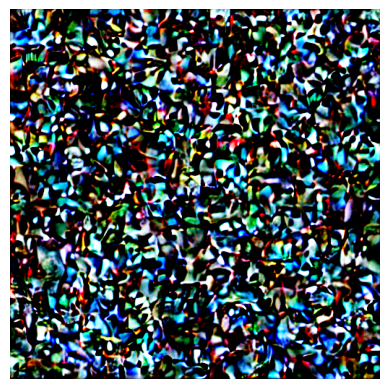

100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


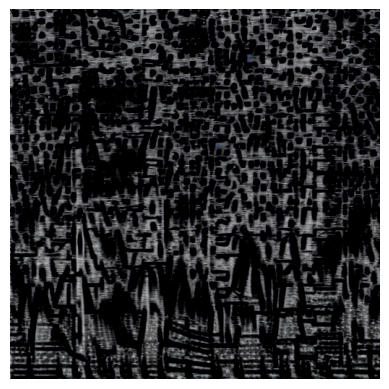